<a href="https://colab.research.google.com/github/ac9989/Class101_ML/blob/main/Ch5_5_Style_transfer(%EC%9C%A0%EB%AA%85%ED%99%94%EA%B0%80%EC%9D%98_%EB%B6%80%ED%99%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 목표
화풍을 기억하여 내용물 그림에 합쳐 고흐의 기억을 가진 인공지능이 창조한 내용물에 덧입도록 함

Style image(화풍,S) + Content image(덧 입힐 대상,C) = Generated image(생성이미지,G)

## 알고리즘
###목적함수
$ L = αL(S,G)+βL(C,G) $
###생성이미지 업데이트
$ G ← G - \frac{\partial L}{\partial G} $

##준비물: VGG19 network
이미 학습된 네트워크 모델로, 이 파라미터 중 필요한 부분만 사용할 것

19번의 연산을 통해 1000여개의 물체를 구분함

224X224X3 => 224X224X64 => 56X56X256 => 28X28X512 => 14X14X512 => 7X7X512 => 1X1X4096 => 1X1X1000

앞에서 차례로 Conv_1, Conv_2, Conv_3, Conv_4, Conv_5
##목적함수 분석 1)Content loss
$ L = αL(S,G)+βL(C,G) $ 중 $L(C,G)$의 의미 : Generated image와 Content image의 Loss함수, 즉 두 이미지를 비슷하게 만듦

###Content loss함수
$L(C,G) = \sum (Act_c - Act_g)^2 $

$Act_c$ : Content 입력의 'Conv_$n$' 통과한 출력 텐서

$Act_g$ : Generated 입력의 'Conv_$n$' 통과한 출력 텐서

=> MSELoss식, 두 입력값을 똑같이 만들어버리기

##목적함수 분석 2)Style loss
$ L = αL(S,G)+βL(C,G) $ 중 $L(S,G)$의 의미 : Generated image의 화풍과 Content image 화풍의 Loss함수, 즉 두 이미지의 화풍을 비슷하게 만듦

###Style loss함수
$L(S,G) = \sum (G_s - G_g)^2 $

$G_s$ : Style 입력 - 출력 텐서의 Gram matrix

$G_g$ : Generated 입력 - 출력 텐서의 Gram matrix

### Gram matrix
원래 input이미지가 채널이 3개라면, Conv_1연산을 통해 채널이 두꺼워짐

- 이 채널 중 하나를 꺼내 분색해보면 원?경계선?삼각형?색? 이런 이미지와 관련된 요소를 담고있음 => 따라서 채널 하나하나가 화풍이 됨

이 때 출력텐서에 여러 채널이 존재하는데 채널간의 관계로 Gram matrix를 정의할 수 있게됨($n_c$ = 채널의 개수)

$G = \begin{bmatrix}
e(1,1) & \cdots & e(1,n_c ) \\
\vdots & \ddots & \vdots \\
e(n_c ,1) & \cdots & e(n_c ,n_c )
\end{bmatrix}$


- $e(i,j) = \sum $채널$i$커널⊗채널$j$커널 : ⊗원소끼리 곱

- 두 행렬의 원소끼리 곱의 합(스칼라값)이 클수록(= i와 j번째 채널의 스타일이 유사할수록) 더 높은 신호를 보낸다

따라서 G는 대칭행렬

# Neural style transfer

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [27]:
device = torch.device('cuda' if torch.cuda. is_available() else 'cpu')
imsize = 512 if torch.cuda. is_available() else 128 

loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.ToTensor()])
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return torch.Tensor(image).to(device)

c_img = image_loader('./5-8 Content.jpg')
s_img = image_loader('./5-8 Style.jpg')

In [28]:
unloader = transforms.ToPILImage() 
# 텐서형태의 이미지를 육안으로 확인가능한 자료형태로 바꾸고 그 이미지를 터미널에서 바로 출력하도록 함

def imshow(tensor):
    image = tensor.cpu().clone()
    image = torch.squeeze(image)
    image = unloader(image)
    plt.imshow(image)

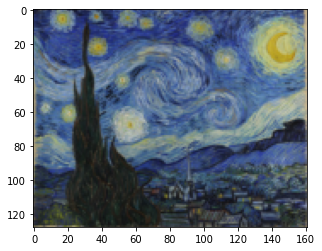

In [29]:
imshow(s_img)

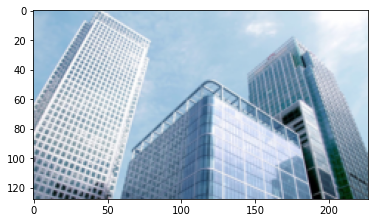

In [30]:
imshow(c_img)

# Content Loss
 $ L_c = L(C,G) $

 $ L(C,G) = ∑(Act_c - Act_g)^2 $

In [34]:
def C_loss(target,infer):
  '''
  target: 컨텐츠 입력 --> 출력텐서
  infer: 생성 입력 --> 출력텐서
  '''
  return torch.mean((target-infer)**2)

# Style Loss
$L_g = L(S,G)$

$L(S,G) = ∑ (G_s - G_g)^2 $

In [35]:
def g_matrix(act):
  '''
  act: 스타일(생성된 이미지 포함) 입력 --> 출력텐서
  목표
  (batch,channel,width,height) --> (batch,channel,channel) 형태로 변환
  '''
  b,c,w,h = act.shape
  act = act.view(c,w*h) #b는 1
  gram = torch.matmul(act,act.T) #행렬곱 : (c x (w * h))*((w *  h) * c) --> (c,c)
  return gram # /(c*w*h)

def S_loss(target,infer):
  '''
  target: 스타일 입력 --> 출력텐서
  infer: 생성 입력 --> 출력텐서
  '''
  #gram matrix 변환
  target = g_matrix(target)
  infer = g_matrix(infer)
  return torch.mean((target-infer)**2)

# VGG19 모델 호출
 -> 깊이있게보지는말래...ㅠ

In [36]:
# torchvision 내부에 있는 VGG19 model 호출
# 주의! 학습대상은 이미지이지 Neural network의 parameter가 아님
# model.eval()
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [37]:
# VGG19 모델 중 필요한 부분만 추출
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [46]:
#우리가 실제로 사용할 부분(단계)을 class로 빼놓자
class Style_transfer_cnn(nn.Module):
  def __init__(self):
    super(Style_transfer_cnn,self).__init__()
    #self.model_list = [0,4,9,18,27]
    self.model_list = [0,5,10,19,28]
    self.model = models.vgg19(pretrained=True).features[:29]
 
    self.mean = torch.Tensor([0.5,0.5,0.5]).to(device)
    self.std = torch.Tensor([0.25,0.25,0.25]).to(device)

  def channel_normalization(self,tensor):
    '''
    image output tensor channel part normaliztion
    z = (x-mu)/std
    '''    
    b,c,w,h = tensor.shape
    mean = self.mean.view(-1,1,1)
    std = self.std.view(-1,1,1)
    return (tensor-mean)/std

  def forward(self,x):
    features = []
    # x = self.channel_normalization(x)
    for idx,layer in enumerate(self.model):  # 0,5,10,19,28
      x = layer(x)
      if idx in self.model_list:
        features.append(x)
    return features

In [47]:
# Generated 이미지를 최적화
# optimizer --> image derivative
# g <-- g-dL/dg

g_img = c_img.clone().requires_grad_(True)
# g_img = 0.9*c_img + 0.1*torch.randn(c_img.shape).to(device) :
# 난수(잡음)가 들어가면 더 결과가 잘 나온다는 연구가 있다고 함
optimizer = optim.Adam([g_img.requires_grad_()],lr=0.01)

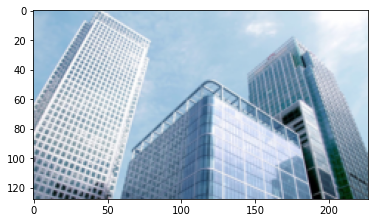

In [48]:
imshow(g_img)

In [49]:
# style 비중, content 비중 스스로도 선택가능합니다.
# 여기선 style의 비중을 40, content의 비중을 10으로 두고 시작해보자

def entire_loss(gens,cons,stys):
  sl,cl = 0,0
  for gen,con,sty in zip(gens,cons,stys):
    cl += 0.2*C_loss(con,gen)
    sl += 0.2*S_loss(sty,gen)
  total = 10*cl + 40*sl
  return total,sl,cl

In [50]:
# Training 시작
model = Style_transfer_cnn().to(device)
for ep in range(1000):
  g_img_pre = torch.mean(g_img)
  gen_feature = model(g_img) #generate 이미지 --> conv_1, conv_2, conv_3, conv_4, conv_5
  con_feature = model(c_img) #content 이미지 --> conv_1, conv_2, conv_3, conv_4, conv_5
  sty_feature = model(s_img) #style 이미지 --> conv_1, conv_2, conv_3, conv_4, conv_5

  loss,sl,cl = entire_loss(gen_feature,con_feature,sty_feature)

  optimizer.zero_grad()
  loss.backward(retain_graph=True)
  optimizer.step()
  g_img_fut = torch.mean(g_img)

  if ep%100 == 0:
    print('-'*20)
    print('Epoch {}'.format(ep))
    print('Style Loss {}, Content Loss {}'.format(sl,cl))

--------------------
Epoch 0
Style Loss 1076612.125, Content Loss 0.0
--------------------
Epoch 100
Style Loss 115111.2734375, Content Loss 5.410311698913574
--------------------
Epoch 200
Style Loss 106403.8359375, Content Loss 5.488048553466797
--------------------
Epoch 300
Style Loss 101719.4609375, Content Loss 5.533351898193359
--------------------
Epoch 400
Style Loss 98673.625, Content Loss 5.579775810241699
--------------------
Epoch 500
Style Loss 96149.9140625, Content Loss 5.5798234939575195
--------------------
Epoch 600
Style Loss 94039.6328125, Content Loss 5.57063102722168
--------------------
Epoch 700
Style Loss 92462.1015625, Content Loss 5.613101959228516
--------------------
Epoch 800
Style Loss 91068.0078125, Content Loss 5.616395950317383
--------------------
Epoch 900
Style Loss 89910.9609375, Content Loss 5.648232460021973


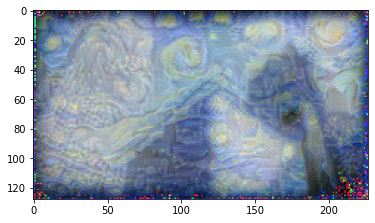

In [51]:
imshow(g_img)

image = g_img.cpu().clone()
image = torch.squeeze(image)
image = unloader(image)
image.save('./Style_content_mixed.png','PNG')